In [101]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import datetime
import string
from string import digits
import collections
import scipy.stats as scs
import cc_pipeline as P
import time

#sentiment and language
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
import vaderSentiment
from langdetect import detect
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import knee_locator




#plotting
from bokeh.plotting import figure, show, output_notebook
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')





#tim https://s3.amazonaws.com/adm-mpeg-dash/gnvideostream/ENSWERCCR7_48_2/KCPQ_FOX_SEATTLE/ccaptions/2018/08/10/d871a12943c40894b2ef9a244dd5704a.cc

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Capturing the mood of TV shows, broadcast stations, and top 100 brands based on subtitles

In [2]:
#file too large to load via read_json

# data = 'data/cc_chunks.json'
# df = pd.read_json(data)


In [27]:
# example closed caption text for one line in .json
# want to include 'data' in json via python script

with open('data/example.txt') as f: 
    data = f.readlines() 

data_joined = " ".join(data) #join as string with linebreaks
data_joined = data_joined.strip().split() #joins text as wordlist
print(data_joined[:40])

['1533919500396', '1068', 'YEAR', 'SEAHAWKS', 'TEAM', 'INCLUDING', 'SOMEONE', 'WHO', 'IMPRESS', 'A', 'WHOLE', 'LOT', '1533919501464', '1134', 'SOMEONE', 'WHO', 'IMPRESS', 'A', 'WHOLE', 'LOT', 'OF', 'PEOPLE.', '1533919502599', '834', 'OF', 'PEOPLE.', 'ALL', 'ACROSS', 'THE', 'COUNTRY', 'WITH', 'HIS', '1533919503433', '2402', 'ALL', 'ACROSS', 'THE', 'COUNTRY', 'WITH', 'HIS']


In [39]:
#join text as string with linebreaks

data_joined = " ".join(data)
data_joined[:100]

'1533919500396\n 1068\n YEAR SEAHAWKS TEAM INCLUDING\n SOMEONE WHO IMPRESS A WHOLE LOT\n \n 1533919501464\n'

In [40]:
#join text as word list

data_joined = data_joined.strip().split()

In [41]:
data_joined[:10]

['1533919500396',
 '1068',
 'YEAR',
 'SEAHAWKS',
 'TEAM',
 'INCLUDING',
 'SOMEONE',
 'WHO',
 'IMPRESS',
 'A']

In [124]:
!head -n 1 data/cc_chunks.json

{"_id":{"$oid":"5b4d62c727eca30007beed65"},"tui":"251537479","duration":900000,"lang":"dflt","machine_id":"ENSWERCCR7_247","url":"https://s3.amazonaws.com/adm-mpeg-dash/gnvideostream/ENSWERCCR7_247/UNIMAS_KFTR/ccaptions/2018/07/17/27514dda124948367b7f4e97d3e79064.cc","created_at":{"$date":"2018-07-17T03:30:15.231Z"},"ts":{"$numberLong":"1531797300000"},"tv":{"$date":"2018-07-17T03:15:00.000Z"},"zip_url":"https://s3.amazonaws.com/adm-mpeg-dash/gnvideostream/ENSWERCCR7_247/UNIMAS_KFTR/ccaptions/2018/07/17/27514dda124948367b7f4e97d3e79064.cc.gz","channel":"UNIMAS_KFTR"}


In [2]:
!tail -n 1 data/cc_chunks.json

{"_id":{"$oid":"5bd28b83687a5f000715b26e"},"tui":"251543425","duration":900000,"lang":"dflt","machine_id":"ENSWERCCR7_141_126","url":"https://s3.amazonaws.com/adm-mpeg-dash/gnvideostream/ENSWERCCR7_141_126/WTVR_CBS_RICHMOND/ccaptions/2018/10/26/dfd48d8b3935698567c1c3bb00dcef37.cc","created_at":{"$date":"2018-10-26T03:35:31.212Z"},"ts":{"$numberLong":"1540523700000"},"tv":{"$date":"2018-10-26T03:15:00.000Z"},"zip_url":"https://s3.amazonaws.com/adm-mpeg-dash/gnvideostream/ENSWERCCR7_141_126/WTVR_CBS_RICHMOND/ccaptions/2018/10/26/dfd48d8b3935698567c1c3bb00dcef37.cc.gz","channel":"WTVR_CBS_RICHMOND"}


In [17]:
!wc -l data/cc_chunks.json

 4519355 data/cc_chunks.json


In [2]:
# # raw metadata links broken

# #max_records = 100000
# data = 'data/cc_chunks.json'
# chunks = pd.read_json(data, lines=True, chunksize=10000)
# filtered_data = pd.DataFrame()

# try:
#     for df_chunk in chunks:
#         chunk_data = pd.concat([filtered_data, df_chunk])
#         break
        
# except ValueError:
#        print ('\nSome messages in the file cannot be parsed')
        
# chunk_data.head()

,_id,channel,created_at,duration,lang,machine_id,ts,tui,tv,url,zip_url
0,{'$oid': '5b4d62c727eca30007beed65'},UNIMAS_KFTR,{'$date': '2018-07-17T03:30:15.231Z'},900000,dflt,ENSWERCCR7_247,{'$numberLong': '1531797300000'},251537479,{'$date': '2018-07-17T03:15:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...
1,{'$oid': '5b4d62c90d730f0007e4ccce'},TV_LAND,{'$date': '2018-07-17T03:30:17.122Z'},900000,dflt,ENSWERCCR4_22,{'$numberLong': '1531797300000'},251536903,{'$date': '2018-07-17T03:15:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...
2,{'$oid': '5b4d62c9265e7500079d0956'},NICK_JUNIOR_SD,{'$date': '2018-07-17T03:30:17.558Z'},900000,dflt,ENSWERCCR4_ingest188,{'$numberLong': '1531797300000'},251534646,{'$date': '2018-07-17T03:15:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...
3,{'$oid': '5b4d62c9265e7500079d0957'},PARAMOUNT_NETWORK_HD,{'$date': '2018-07-17T03:30:17.845Z'},900000,dflt,ENSWERCCR4_ingest188,{'$numberLong': '1531797300000'},251536777,{'$date': '2018-07-17T03:15:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...
4,{'$oid': '5b4d62c9a9d31800075c4771'},OXYGEN_HD,{'$date': '2018-07-17T03:30:17.383Z'},900000,dflt,ENSWERCCR2_ingest206,{'$numberLong': '1531797300000'},251544242,{'$date': '2018-07-17T03:15:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...


In [2]:
# # raw metadata

# #max_records = 100000
# data = 'data/cc_chunks.json'
# chunks = pd.read_json(data, lines=True, chunksize=10000)
# filtered_data = pd.DataFrame()

# for i, chunk in enumerate( chunks ):
#     break
    
# chunk.head()

# # try:
# #     for df_chunk in chunks:
# #         filtered_data = pd.concat([filtered_data, df_chunk])
# #         break
        
# # except ValueError:
# #        print ('\nSome messages in the file cannot be parsed')
        
# # filtered_data.head()

,_id,channel,created_at,duration,lang,machine_id,ts,tui,tv,url,zip_url
0,{'$oid': '5b4d62c727eca30007beed65'},UNIMAS_KFTR,{'$date': '2018-07-17T03:30:15.231Z'},900000,dflt,ENSWERCCR7_247,{'$numberLong': '1531797300000'},251537479,{'$date': '2018-07-17T03:15:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...
1,{'$oid': '5b4d62c90d730f0007e4ccce'},TV_LAND,{'$date': '2018-07-17T03:30:17.122Z'},900000,dflt,ENSWERCCR4_22,{'$numberLong': '1531797300000'},251536903,{'$date': '2018-07-17T03:15:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...
2,{'$oid': '5b4d62c9265e7500079d0956'},NICK_JUNIOR_SD,{'$date': '2018-07-17T03:30:17.558Z'},900000,dflt,ENSWERCCR4_ingest188,{'$numberLong': '1531797300000'},251534646,{'$date': '2018-07-17T03:15:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...
3,{'$oid': '5b4d62c9265e7500079d0957'},PARAMOUNT_NETWORK_HD,{'$date': '2018-07-17T03:30:17.845Z'},900000,dflt,ENSWERCCR4_ingest188,{'$numberLong': '1531797300000'},251536777,{'$date': '2018-07-17T03:15:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...
4,{'$oid': '5b4d62c9a9d31800075c4771'},OXYGEN_HD,{'$date': '2018-07-17T03:30:17.383Z'},900000,dflt,ENSWERCCR2_ingest206,{'$numberLong': '1531797300000'},251544242,{'$date': '2018-07-17T03:15:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...


In [1]:
# #create list of chunks then concat list
# #10min to load

# data = 'data/cc_chunks.json'
# chunks = pd.read_json(data, lines=True, chunksize=10000)

# chunks_list = []
# for i, chunk in enumerate( chunks ):
#     chunks_list.append(chunk)
    
# len(chunks_list)

In [582]:
#8min to load

# df = pd.concat( chunks_list )

In [41]:
#write to csv (index = false)
#index at dates 
#write to csv (index = false)



(4519355, 11)

In [584]:
#create date series for boolean filtering after October

date_series = pd.Series(df['created_at'].values)

In [585]:
#15min

dates = date_series.apply(lambda x: x.get('$date'))

In [49]:
#namespace loaded

dates[2259682:2259692]

2259682    2018-09-05T16:16:15.951Z
2259683    2018-09-05T16:16:15.127Z
2259684    2018-09-05T16:16:16.834Z
2259685    2018-09-05T16:16:16.179Z
2259686    2018-09-05T16:16:16.248Z
2259687    2018-09-05T16:16:16.798Z
2259688    2018-09-05T16:16:18.420Z
2259689    2018-09-05T16:16:20.989Z
2259690    2018-09-05T16:16:20.397Z
2259691    2018-09-05T16:16:21.198Z
dtype: object

In [586]:
#create datetime col for boolean

df['date'] = pd.to_datetime(dates)

In [587]:
#15min to run

df_new = df.loc[pd.to_datetime(df['date'].dt.date) > '2018-10-01'].reset_index()
df_new.head()

,index,_id,channel,created_at,duration,lang,machine_id,ts,tui,tv,url,zip_url,date
0,3434672,{'$oid': '5bb2b5082c1ba60007fc013d'},WBNX_HD_CW,{'$date': '2018-10-02T00:00:08.982Z'},900000,dflt,ENSWERCCR7_8_3,{'$numberLong': '1538437500000'},251536767,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:08.982
1,3434673,{'$oid': '5bb2b5106f40ed000728b879'},KZJO_MY_NETWORK_SEATTLE,{'$date': '2018-10-02T00:00:16.702Z'},900000,dflt,ENSWERCCR7_48_2,{'$numberLong': '1538437500000'},251533435,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:16.702
2,3434674,{'$oid': '5bb2b51170969a000bc9a14e'},WVUA_THIS_TV_BIRMINGHAM,{'$date': '2018-10-02T00:00:17.995Z'},900000,dflt,ENSWERCCR7_65_236,{'$numberLong': '1538435700000'},251541606,{'$date': '2018-10-01T23:15:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:17.995
3,3434675,{'$oid': '5bb2b51187701400079ec41d'},TV_LAND,{'$date': '2018-10-02T00:00:17.925Z'},900000,dflt,ENSWERCCR4_22,{'$numberLong': '1538437500000'},251536903,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:17.925
4,3434676,{'$oid': '5bb2b511b18af90007b4e445'},WPCH_INDEPENDENT_ATLANTA,{'$date': '2018-10-02T00:00:17.074Z'},900000,dflt,ENSWERCCR7_7_245,{'$numberLong': '1538437500000'},251534109,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:17.074


In [122]:
df_new['url'][0]

'https://s3.amazonaws.com/adm-mpeg-dash/gnvideostream/ENSWERCCR7_8_3/WBNX_HD_CW/ccaptions/2018/10/01/393cd7c008e0f5c24c2d30be1371afa6.cc'

In [9]:
df_new.shape

(1084683, 13)

In [ ]:
df_new.tail()

In [588]:
#write to csv

#df_new.to_csv('data/cc_recent.csv', encoding='utf-8', index=False)

In [51]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1084683 entries, 0 to 1084682
Data columns (total 13 columns):
index         1084683 non-null int64
_id           1084683 non-null object
channel       1084683 non-null object
created_at    1084683 non-null object
duration      1084683 non-null int64
lang          1084683 non-null object
machine_id    1084683 non-null object
ts            1084683 non-null object
tui           1084683 non-null int64
tv            1084683 non-null object
url           1084683 non-null object
zip_url       1084683 non-null object
date          1084683 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(9)
memory usage: 107.6+ MB


In [590]:
#write 1000 entries
df_small = df_new.head(1000)
#df_small.to_csv('data/cc_1000.csv', encoding='utf-8', index=False)

## EXTRACTING TEXT

In [23]:
text_df = pd.read_csv('data/cc_recent.csv', encoding='utf-8')
text_df.head()

,_id,channel,created_at,duration,lang,machine_id,ts,tui,tv,url,zip_url,date
0,{'$oid': '5bb2b5082c1ba60007fc013d'},WBNX_HD_CW,{'$date': '2018-10-02T00:00:08.982Z'},900000,dflt,ENSWERCCR7_8_3,{'$numberLong': '1538437500000'},251536767,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:08.982
1,{'$oid': '5bb2b5106f40ed000728b879'},KZJO_MY_NETWORK_SEATTLE,{'$date': '2018-10-02T00:00:16.702Z'},900000,dflt,ENSWERCCR7_48_2,{'$numberLong': '1538437500000'},251533435,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:16.702
2,{'$oid': '5bb2b51170969a000bc9a14e'},WVUA_THIS_TV_BIRMINGHAM,{'$date': '2018-10-02T00:00:17.995Z'},900000,dflt,ENSWERCCR7_65_236,{'$numberLong': '1538435700000'},251541606,{'$date': '2018-10-01T23:15:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:17.995
3,{'$oid': '5bb2b51187701400079ec41d'},TV_LAND,{'$date': '2018-10-02T00:00:17.925Z'},900000,dflt,ENSWERCCR4_22,{'$numberLong': '1538437500000'},251536903,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:17.925
4,{'$oid': '5bb2b511b18af90007b4e445'},WPCH_INDEPENDENT_ATLANTA,{'$date': '2018-10-02T00:00:17.074Z'},900000,dflt,ENSWERCCR7_7_245,{'$numberLong': '1538437500000'},251534109,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:17.074


In [9]:
#text_df = pd.read_csv('data/cc_recent.csv', encoding='utf-8')
#text_df = text_df.drop(columns=['index'])
#text_df.to_csv('data/october_raw_noindex.csv', encoding='utf-8', index=False)
text_df.head()

,_id,channel,created_at,duration,lang,machine_id,ts,tui,tv,url,zip_url,date
0,{'$oid': '5bb2b5082c1ba60007fc013d'},WBNX_HD_CW,{'$date': '2018-10-02T00:00:08.982Z'},900000,dflt,ENSWERCCR7_8_3,{'$numberLong': '1538437500000'},251536767,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:08.982
1,{'$oid': '5bb2b5106f40ed000728b879'},KZJO_MY_NETWORK_SEATTLE,{'$date': '2018-10-02T00:00:16.702Z'},900000,dflt,ENSWERCCR7_48_2,{'$numberLong': '1538437500000'},251533435,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:16.702
2,{'$oid': '5bb2b51170969a000bc9a14e'},WVUA_THIS_TV_BIRMINGHAM,{'$date': '2018-10-02T00:00:17.995Z'},900000,dflt,ENSWERCCR7_65_236,{'$numberLong': '1538435700000'},251541606,{'$date': '2018-10-01T23:15:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:17.995
3,{'$oid': '5bb2b51187701400079ec41d'},TV_LAND,{'$date': '2018-10-02T00:00:17.925Z'},900000,dflt,ENSWERCCR4_22,{'$numberLong': '1538437500000'},251536903,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:17.925
4,{'$oid': '5bb2b511b18af90007b4e445'},WPCH_INDEPENDENT_ATLANTA,{'$date': '2018-10-02T00:00:17.074Z'},900000,dflt,ENSWERCCR7_7_245,{'$numberLong': '1538437500000'},251534109,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:17.074


,_id,channel,created_at,duration,lang,machine_id,ts,tui,tv,url,zip_url,date,text
0,{'$oid': '5bb2b5082c1ba60007fc013d'},WBNX_HD_CW,{'$date': '2018-10-02T00:00:08.982Z'},900000,dflt,ENSWERCCR7_8_3,{'$numberLong': '1538437500000'},251536767,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:08.982,1538437621406\n1835\n[ KNOCK ON DOOR ]\n\n1538...
1,{'$oid': '5bb2b5106f40ed000728b879'},KZJO_MY_NETWORK_SEATTLE,{'$date': '2018-10-02T00:00:16.702Z'},900000,dflt,ENSWERCCR7_48_2,{'$numberLong': '1538437500000'},251533435,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:16.702,"1538437521225\n1435\nSeen it, covered it.\n\n1..."
2,{'$oid': '5bb2b51170969a000bc9a14e'},WVUA_THIS_TV_BIRMINGHAM,{'$date': '2018-10-02T00:00:17.995Z'},900000,dflt,ENSWERCCR7_65_236,{'$numberLong': '1538435700000'},251541606,{'$date': '2018-10-01T23:15:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:17.995,1538435707355\n4571\n\n\n\n1538435711926\n23...
3,{'$oid': '5bb2b51187701400079ec41d'},TV_LAND,{'$date': '2018-10-02T00:00:17.925Z'},900000,dflt,ENSWERCCR4_22,{'$numberLong': '1538437500000'},251536903,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:17.925,1538437500869\n2653\nWe’ll talk later.\n\n1538...
4,{'$oid': '5bb2b511b18af90007b4e445'},WPCH_INDEPENDENT_ATLANTA,{'$date': '2018-10-02T00:00:17.074Z'},900000,dflt,ENSWERCCR7_7_245,{'$numberLong': '1538437500000'},251534109,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:17.074,1538437500144\n1201\nIt hurts.\n\n153843750218...


In [3]:
# text extract function

from socket import error as SocketError
import errno

def scrape_text(series):
    
    #use pd.series instead moving forward
    text = []
    for link in series:
        
        try:
            req = Request(link, headers={'User-Agent': 'Mozilla/5.0'})
            webpage = urlopen(req).read()
            webpage = webpage.decode('utf-8')
            text.append(webpage)
        except SocketError as e:
            if e.errno != errno.ECONNRESET:
                raise # Not error we are looking for
            pass # Handle error here.
        
    return text

In [4]:
#def scrape_urls(chunck_size=1000, iterations):


from_df = pd.read_csv('data/cc_recent.csv', encoding='utf-8')
temp_df = from_df.head(1000)

#scrape text then concat
text_url_series = pd.Series(temp_df['url'])
extracts = scrape_text(text_url_series)
extracts = pd.Series(extracts)
temp_df['text'] = extracts

head_df = pd.read_csv('data/cc_head_text.csv', encoding='utf-8')
head_df = pd.concat([head_df, temp_df])
head_df.to_csv('data/cc_head_text.csv', encoding='utf-8', index=False)

from_df = from_df.drop(from_df.index[0:1000])
from_df.to_csv('data/cc_recent.csv', encoding='utf-8', index=False)

head_df=None
temp_df=None
from_df=None
text_url_series=None
extracts=None

URLError: <urlopen error [Errno 110] Connection timed out>

,_id,channel,created_at,duration,lang,machine_id,ts,tui,tv,url,zip_url,date,text
3995,{'$oid': '5bb2df5c687a5f0007ea212f'},WRIC_ABC_RICHMOND,{'$date': '2018-10-02T03:00:44.789Z'},900000,dflt,ENSWERCCR7_141_126,{'$numberLong': '1538448300000'},251538003,{'$date': '2018-10-02T02:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 03:00:44.789,1538448302025\n2202\noverreaction is the only\...
3996,{'$oid': '5bb2df5c94f50d0007f38b0b'},NFL_NETWORK_HD,{'$date': '2018-10-02T03:00:44.532Z'},900000,dflt,ENSWERCCR9_NATPEORIA28,{'$numberLong': '1538448300000'},251540074,{'$date': '2018-10-02T02:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 03:00:44.532,1538448300516\n1502\nthat great.\n>> Bradshaw ...
3997,{'$oid': '5bb2df5cbac8860007c39f3c'},WRDQ_INDEPENDENT_ORLANDO,{'$date': '2018-10-02T03:00:44.646Z'},900000,dflt,ENSWERCCR7_70_74,{'$numberLong': '1538448300000'},251534714,{'$date': '2018-10-02T02:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 03:00:44.646,1538448319810\n1268\n>>> A COUPLE TOOK THEIR C...
3998,{'$oid': '5bb2df5d57c5500007ff7158'},WSTR_MY_NETWORK_CINCINNATI,{'$date': '2018-10-02T03:00:45.966Z'},900000,dflt,ENSWERCCR7_85_170,{'$numberLong': '1538448300000'},251535028,{'$date': '2018-10-02T02:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 03:00:45.966,1538448400152\n1101\n♪ ♪\n\n1538448401254\n183...
3999,{'$oid': '5bb2df5d63380e000789afc5'},SHO_EAST_HD,{'$date': '2018-10-02T03:00:45.006Z'},900000,dflt,ENSWERCCR2_54_245,{'$numberLong': '1538448300000'},251540607,{'$date': '2018-10-02T02:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 03:00:45.006,1538448301728\n1084\nwithin a week.\n\n1538448...


In [5]:
#scrape at intervals

def scrape_from_url(cycles):
    
    for i in range(cycles):
        
        from_df = pd.read_csv('data/cc_recent.csv', encoding='utf-8')
        temp_df = from_df.head(1000)

        #scrape text then concat
        text_url_series = pd.Series(temp_df['url'])
        extracts = scrape_text(text_url_series)
        extracts = pd.Series(extracts)
        temp_df['text'] = extracts

        head_df = pd.read_csv('data/cc_head_text.csv', encoding='utf-8')
        head_df = pd.concat([head_df, temp_df])
        head_df.to_csv('data/cc_head_text.csv', encoding='utf-8', index=False)

        from_df = from_df.drop(from_df.index[0:1000])
        from_df.to_csv('data/cc_recent.csv', encoding='utf-8', index=False)

        head_df=None
        temp_df=None
        from_df=None
        text_url_series=None
        extracts=None
        
        time.sleep(900)
        
        
    


In [ ]:
scrape_from_url(2)

In [17]:
#url example

text_df['url'].loc[:0].values

array(['https://s3.amazonaws.com/adm-mpeg-dash/gnvideostream/ENSWERCCR7_8_3/WBNX_HD_CW/ccaptions/2018/10/01/393cd7c008e0f5c24c2d30be1371afa6.cc'],
      dtype=object)

In [ ]:
#EC2

ssh -i ~/.ssh/alberto_first_key.pem ubuntu@ec2-18-204-204-24.compute-1.amazonaws.com



In [5]:
#from 1000 entries

text_url_series = pd.Series(text_df['url'])

extracts = scrape_text(text_url_series)
extracts[0]

#add to new dataframe and concat upcoming chuncks
#remove first 1000 from dataframe and save

'1538437621406\n1835\n[ KNOCK ON DOOR ]\n\n1538437623274\n1034\nHEY, DAD.\n\n1538437624343\n968\nSON.\n\n1538437625344\n1268\nKNEW IT WAS YOU.\n\n1538437626645\n1502\nYOU’RE THE ONLY ONE\nTHAT STILL KNOCKS.\n\n1538437628180\n1301\nWE HAVE A DOORBELL.\n\n1538437629514\n1368\nOH, FORGIVE ME\nFOR TRYING TO SAVE YOU\n\n1538437630916\n1502\nA COUPLE OF BUCKS\nON ELECTRICITY.\n\n1538437634086\n2636\nI LEFT MY NICOTINE GUM HERE\nTHE OTHER NIGHT.\n\n1538437636755\n1368\nI REALLY NEED IT\n\n1538437638156\n2436\nSINCE I SWITCHED\nTO THOSE LIGHT CIGARETTES.\n\n1538437640626\n1668\nSO THAT’S\nWHAT THAT IS.\n\n1538437642327\n2336\nI THOUGHT IT WAS A CHICLET\nTHAT HAD GONE BAD.\n\n1538437644696\n1969\nEXPLAINS WHY I COULDN’T STOP\nCHEWING IT.\n\n1538437648166\n1702\nIT’S A PRETTY GOOD GAME.\n\n1538437649901\n2035\nWANT TO STICK AROUND\nAND WATCH?\n\n1538437651970\n2236\nI GUESS.\n\n1538437654239\n2035\nYOU KNOW,\nTHE OTHER NIGHT,\n\n1538437656307\n2536\nWHEN I WAS TALKING\nABOUT SPANKING,\n\n1538437

In [ ]:
#overwrite with each concat

trunc_df.to_csv('data/cc_chunk_concat.csv', encoding='utf-8', index=False)

In [6]:
extracts = pd.Series(extracts)

In [7]:
text_df['text'] = extracts

In [8]:
text_df.head()

,index,_id,channel,created_at,duration,lang,machine_id,ts,tui,tv,url,zip_url,date,text
0,3434672,{'$oid': '5bb2b5082c1ba60007fc013d'},WBNX_HD_CW,{'$date': '2018-10-02T00:00:08.982Z'},900000,dflt,ENSWERCCR7_8_3,{'$numberLong': '1538437500000'},251536767,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:08.982,1538437621406\n1835\n[ KNOCK ON DOOR ]\n\n1538...
1,3434673,{'$oid': '5bb2b5106f40ed000728b879'},KZJO_MY_NETWORK_SEATTLE,{'$date': '2018-10-02T00:00:16.702Z'},900000,dflt,ENSWERCCR7_48_2,{'$numberLong': '1538437500000'},251533435,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:16.702,"1538437521225\n1435\nSeen it, covered it.\n\n1..."
2,3434674,{'$oid': '5bb2b51170969a000bc9a14e'},WVUA_THIS_TV_BIRMINGHAM,{'$date': '2018-10-02T00:00:17.995Z'},900000,dflt,ENSWERCCR7_65_236,{'$numberLong': '1538435700000'},251541606,{'$date': '2018-10-01T23:15:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:17.995,1538435707355\n4571\n\n\n\n1538435711926\n23...
3,3434675,{'$oid': '5bb2b51187701400079ec41d'},TV_LAND,{'$date': '2018-10-02T00:00:17.925Z'},900000,dflt,ENSWERCCR4_22,{'$numberLong': '1538437500000'},251536903,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:17.925,1538437500869\n2653\nWe’ll talk later.\n\n1538...
4,3434676,{'$oid': '5bb2b511b18af90007b4e445'},WPCH_INDEPENDENT_ATLANTA,{'$date': '2018-10-02T00:00:17.074Z'},900000,dflt,ENSWERCCR7_7_245,{'$numberLong': '1538437500000'},251534109,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:17.074,1538437500144\n1201\nIt hurts.\n\n153843750218...


In [11]:
#text_df.to_csv('data/cc_1000_text.csv', encoding='utf-8', index=False)
#text_df.to_json('data/cc_1000_text.json')

In [16]:
len(text_df['channel']), len(text_df['channel'].unique())      

(1000, 466)

In [25]:
stations = (text_df['channel'].unique()).tolist()
stations = [x.replace('_', ' ') for x in stations]
stations

['WBNX HD CW',
 'KZJO MY NETWORK SEATTLE',
 'WVUA THIS TV BIRMINGHAM',
 'TV LAND',
 'WPCH INDEPENDENT ATLANTA',
 'KOB NBC ALBUQUERQUE',
 'KATU ABC PORTLAND',
 'KTUL ABC TULSA',
 'ABC FAMILY HD',
 'KXLN UNIVISION HOUSTON',
 'WSNS',
 'WXFT',
 'INVESTIGATION DISCOVERY ID HD',
 'WHAS ABC LOUISVILLE',
 'WWSI TELEMUNDO PHILADELPHIA',
 'CNN HEADLINE NEWS HLN SD',
 'TRUTV EAST HD',
 'KTVW UNIVISION PHOENIX',
 'KNIC UNIMAS SAN ANTONIO',
 'WTTA MY NETWORK TAMPA',
 'DISNEY CHANNEL HD',
 'CBS KCBS HD',
 'ABC KABC HD',
 'WDCA MY NETWORK WASHINGTON DC',
 'KTVX ABC SLC',
 'BRAVO EAST HD',
 'WZDC TELEMUNDO WASHINGTON DC',
 'KINC UNIVISION LAS VEGAS',
 'KMGH ABC DENVER',
 'KWGN CW DENVER',
 'KDVR FOX DENVER',
 'BET EAST SD',
 'KVVU FOX LAS VEGAS',
 'WBFF FOX BALTIMORE',
 'KSHB NBC KC',
 'KSMO MY NETWORK KC',
 'KMBC ABC KC',
 'WJXT INDEPENDENT JACKSONVILLE',
 'NFL NETWORK HD',
 'WSFL CW MIAMI',
 'WRDM TELEMUNDO HARTFORD',
 'KCNC CBS DENVER',
 'KFMB CBS SAN DIEGO',
 'KSWB FOX SAN DIEGO',
 'KGTV ABC SAN D

In [19]:
# number of unique channels in october

(text_df['channel'].unique()).size

471

In [20]:
# number of shows in october

text_df.size

14100879

## Text Analysis

In [380]:
df_nano = pd.read_csv('data/cc_100_text.csv', encoding='utf-8')
df_nano.head()

,index,_id,channel,created_at,duration,lang,machine_id,ts,tui,tv,url,zip_url,date,text
0,3434672,{'$oid': '5bb2b5082c1ba60007fc013d'},WBNX_HD_CW,{'$date': '2018-10-02T00:00:08.982Z'},900000,dflt,ENSWERCCR7_8_3,{'$numberLong': '1538437500000'},251536767,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:08.982,1538437621406\n1835\n[ KNOCK ON DOOR ]\n\n1538...
1,3434673,{'$oid': '5bb2b5106f40ed000728b879'},KZJO_MY_NETWORK_SEATTLE,{'$date': '2018-10-02T00:00:16.702Z'},900000,dflt,ENSWERCCR7_48_2,{'$numberLong': '1538437500000'},251533435,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:16.702,"1538437521225\n1435\nSeen it, covered it.\n\n1..."
2,3434674,{'$oid': '5bb2b51170969a000bc9a14e'},WVUA_THIS_TV_BIRMINGHAM,{'$date': '2018-10-02T00:00:17.995Z'},900000,dflt,ENSWERCCR7_65_236,{'$numberLong': '1538435700000'},251541606,{'$date': '2018-10-01T23:15:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:17.995,1538435707355\n4571\n\n\n\n1538435711926\n23...
3,3434675,{'$oid': '5bb2b51187701400079ec41d'},TV_LAND,{'$date': '2018-10-02T00:00:17.925Z'},900000,dflt,ENSWERCCR4_22,{'$numberLong': '1538437500000'},251536903,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:17.925,1538437500869\n2653\nWe’ll talk later.\n\n1538...
4,3434676,{'$oid': '5bb2b511b18af90007b4e445'},WPCH_INDEPENDENT_ATLANTA,{'$date': '2018-10-02T00:00:17.074Z'},900000,dflt,ENSWERCCR7_7_245,{'$numberLong': '1538437500000'},251534109,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:17.074,1538437500144\n1201\nIt hurts.\n\n153843750218...


In [26]:
msgs = text_df['text'].values
list_msgs = msgs.tolist()
list_msgs[0]


'1538437621406\n1835\n[ KNOCK ON DOOR ]\n\n1538437623274\n1034\nHEY, DAD.\n\n1538437624343\n968\nSON.\n\n1538437625344\n1268\nKNEW IT WAS YOU.\n\n1538437626645\n1502\nYOU’RE THE ONLY ONE\nTHAT STILL KNOCKS.\n\n1538437628180\n1301\nWE HAVE A DOORBELL.\n\n1538437629514\n1368\nOH, FORGIVE ME\nFOR TRYING TO SAVE YOU\n\n1538437630916\n1502\nA COUPLE OF BUCKS\nON ELECTRICITY.\n\n1538437634086\n2636\nI LEFT MY NICOTINE GUM HERE\nTHE OTHER NIGHT.\n\n1538437636755\n1368\nI REALLY NEED IT\n\n1538437638156\n2436\nSINCE I SWITCHED\nTO THOSE LIGHT CIGARETTES.\n\n1538437640626\n1668\nSO THAT’S\nWHAT THAT IS.\n\n1538437642327\n2336\nI THOUGHT IT WAS A CHICLET\nTHAT HAD GONE BAD.\n\n1538437644696\n1969\nEXPLAINS WHY I COULDN’T STOP\nCHEWING IT.\n\n1538437648166\n1702\nIT’S A PRETTY GOOD GAME.\n\n1538437649901\n2035\nWANT TO STICK AROUND\nAND WATCH?\n\n1538437651970\n2236\nI GUESS.\n\n1538437654239\n2035\nYOU KNOW,\nTHE OTHER NIGHT,\n\n1538437656307\n2536\nWHEN I WAS TALKING\nABOUT SPANKING,\n\n1538437

In [11]:
hent = pd.read_csv('data/cc_4000_test.csv', encoding='utf-8')
hent.tail()

,_id,channel,created_at,duration,lang,machine_id,ts,tui,tv,url,zip_url,date,text
3995,{'$oid': '5bb2df5c687a5f0007ea212f'},WRIC_ABC_RICHMOND,{'$date': '2018-10-02T03:00:44.789Z'},900000,dflt,ENSWERCCR7_141_126,{'$numberLong': '1538448300000'},251538003,{'$date': '2018-10-02T02:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 03:00:44.789,1538448302025\n2202\noverreaction is the only\...
3996,{'$oid': '5bb2df5c94f50d0007f38b0b'},NFL_NETWORK_HD,{'$date': '2018-10-02T03:00:44.532Z'},900000,dflt,ENSWERCCR9_NATPEORIA28,{'$numberLong': '1538448300000'},251540074,{'$date': '2018-10-02T02:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 03:00:44.532,1538448300516\n1502\nthat great.\n>> Bradshaw ...
3997,{'$oid': '5bb2df5cbac8860007c39f3c'},WRDQ_INDEPENDENT_ORLANDO,{'$date': '2018-10-02T03:00:44.646Z'},900000,dflt,ENSWERCCR7_70_74,{'$numberLong': '1538448300000'},251534714,{'$date': '2018-10-02T02:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 03:00:44.646,1538448319810\n1268\n>>> A COUPLE TOOK THEIR C...
3998,{'$oid': '5bb2df5d57c5500007ff7158'},WSTR_MY_NETWORK_CINCINNATI,{'$date': '2018-10-02T03:00:45.966Z'},900000,dflt,ENSWERCCR7_85_170,{'$numberLong': '1538448300000'},251535028,{'$date': '2018-10-02T02:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 03:00:45.966,1538448400152\n1101\n♪ ♪\n\n1538448401254\n183...
3999,{'$oid': '5bb2df5d63380e000789afc5'},SHO_EAST_HD,{'$date': '2018-10-02T03:00:45.006Z'},900000,dflt,ENSWERCCR2_54_245,{'$numberLong': '1538448300000'},251540607,{'$date': '2018-10-02T02:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 03:00:45.006,1538448301728\n1084\nwithin a week.\n\n1538448...


In [12]:
fmsgs = hent['text'].values
f_msgs = fmsgs.tolist()
f_msgs[3998]

'1538448400152\n1101\n♪ ♪\n\n1538448401254\n1835\n♪ ♪\n>> Jesse: WELCOME BACK.\n\n1538448403089\n2436\n♪ ♪\n>> Jesse: WELCOME BACK.\nWELL, CALL THEM ONE BIG, HAPPY\n\n1538448405524\n601\n>> Jesse: WELCOME BACK.\nWELL, CALL THEM ONE BIG, HAPPY\nFAMILY.\n\n1538448406125\n1268\nWELL, CALL THEM ONE BIG, HAPPY\nFAMILY.\nWE ARE TALKING ABOUT BEN\n\n1538448407393\n1468\nFAMILY.\nWE ARE TALKING ABOUT BEN\nAFFLECK, AND JEN GARNER IN THEIR\n\n1538448408861\n200\nWE ARE TALKING ABOUT BEN\nAFFLECK, AND JEN GARNER IN THEIR\nBRUTE.\n\n1538448409061\n3504\nAFFLECK, AND JEN GARNER IN THEIR\nBRUTE.\nTHAT IS WHAT IS "SERIOUSLY\n\n1538448412565\n367\nBRUTE.\nTHAT IS WHAT IS "SERIOUSLY\nPOPULAR TODAY."\n\n1538448412932\n1168\nTHAT IS WHAT IS "SERIOUSLY\nPOPULAR TODAY."\nHE HAS COMPLETED HIS FIRST 30\n\n1538448414100\n2202\nPOPULAR TODAY."\nHE HAS COMPLETED HIS FIRST 30\nDAYS IN REHAB, AND HERE HE IS\n\n1538448416302\n1034\nHE HAS COMPLETED HIS FIRST 30\nDAYS IN REHAB, AND HERE HE IS\nGETTING INTO FAMILY T

In [13]:
# needs to be a list of strings..apply to function that iterates over list of strings

def get_show_text( show_raw ):
    
    return "\n".join( ["\n".join( x.split("\n")[2:] ) for x in show_raw.split("\n\n")] )


#print(get_show_text(msgs))

In [14]:
#apply in list of strings 
def clean_all_text(text_list):
    
    doc_list = []
    for doc in text_list:

        doc_list = []

        for doc in text_list:
            doc_list.append(get_show_text(doc))
    return doc_list


In [15]:
all_text = clean_all_text(list_msgs)
all_text[1]

NameError: name 'list_msgs' is not defined

In [17]:
#30-45min for 4000 points

#f_text = clean_all_text(f_msgs)
f_text[1]

'Seen it, covered it.\nWe know a thing or two because\nwe’ve seen a thing or two.\nbum-bum-bum-bum ♪\nWe are Farmers. Bum-pa-dum,\n(Burke)\nFender-Biter.\nSeen it, covered it.\nWe know a thing or two because\nwe’ve seen a thing or two.\nbum-bum-bum-bum ♪\nWe are Farmers. Bum-pa-dum,\nOH, HEY, MANDY.\nOH, IT’S A CHRISTMAS PARTY.\nYOU SURE YOU WANT TO BE HERE?\nTHERE’S ONLY FIVE DAYS LEFT IN\nTHE SHOP-FOR-YOURSELF SEASON.\nSHOULDN’T YOU\nBE AT THE MALL?\nDID YOU GUYS EVER\nSTOP TO THINK THAT MAYBE\nINSTEAD OF\nBUYING THINGS FOR MYSELF,\nI’M BUYING A REALLY NICE GIFT\nFOR SOMEBODY ELSE?\nNO.\nSO I JUST --\nI GUESS IT’S TOO MUCH\nTO EXPECT FOR YOU GUYS\nTO EVER JUST TRUST ME?\nYEAH.\nMM. HEY, MANDY, THANKS\nFOR YOUR CHRISTMAS PRESENT.\nOH, I DIDN’T\nGET YOU ANYTHING.\nSURE YOU DID.\nMOM AND DAD HATING YOU\nIS ALL I ASKED FOR\nTHIS YEAR.\nKristin: HEY, GUYS.\nMERRY CHRISTMAS.\nHEY.\nHEY.\nMERRY CHRISTMAS, BOYD.\nMERRY CHRISTMAS, DAD.\nAND MER-- HAPPY --\nYOU KNOW...\nHOW’S YOUR DECEMBER\nTR

In [20]:
digits = ['00',
 '000',
 '01',
 '02',
 '04',
 '06',
 '10',
 '100',
 '10a',
 '10s',
 '11',
 '1100s',
 '110th',
 '112',
 '11th',
 '12',
 '121',
 '124',
 '125',
 '12k6',
 '12th',
 '13',
 '13th',
 '142',
 '15',
 '16',
 '163rd',
 '17',
 '170',
 '18',
 '180',
 '1890s',
 '1942',
 '19th',
 '1st',
 '1xtra',
 '20',
 '200',
 '2015',
 '2018',
 '20s',
 '21st',
 '22',
 '23',
 '24',
 '247',
 '25',
 '25th',
 '26',
 '276',
 '29',
 '2nd',
 '30',
 '300',
 '30th',
 '35th',
 '36',
 '39',
 '3rd',
 '400',
 '405',
 '40s',
 '410',
 '42nd',
 '49ers',
 '50',
 '500',
 '50s',
 '50th',
 '55',
 '590',
 '60',
 '600',
 '601',
 '60s',
 '627',
 '64',
 '65',
 '6th',
 '700',
 '70s',
 '750',
 '76ers',
 '799',
 '7th',
 '80',
 '800',
 '80s',
 '80th',
 '819',
 '825',
 '838',
 '850',
 '86',
 '875',
 '8th',
 '900',
 '90s',
 '99',
 '99th']

In [26]:
hen.head()

,_id,channel,created_at,duration,lang,machine_id,ts,tui,tv,url,zip_url,date,text,cleaned
0,{'$oid': '5bb2b5082c1ba60007fc013d'},WBNX_HD_CW,{'$date': '2018-10-02T00:00:08.982Z'},900000,dflt,ENSWERCCR7_8_3,{'$numberLong': '1538437500000'},251536767,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:08.982,1538437621406\n1835\n[ KNOCK ON DOOR ]\n\n1538...,knock door hey dad son knew was you you the on...
1,{'$oid': '5bb2b5106f40ed000728b879'},KZJO_MY_NETWORK_SEATTLE,{'$date': '2018-10-02T00:00:16.702Z'},900000,dflt,ENSWERCCR7_48_2,{'$numberLong': '1538437500000'},251533435,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:16.702,"1538437521225\n1435\nSeen it, covered it.\n\n1...",seen covered know thing two seen thing two bum...
2,{'$oid': '5bb2b51170969a000bc9a14e'},WVUA_THIS_TV_BIRMINGHAM,{'$date': '2018-10-02T00:00:17.995Z'},900000,dflt,ENSWERCCR7_65_236,{'$numberLong': '1538435700000'},251541606,{'$date': '2018-10-01T23:15:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:17.995,1538435707355\n4571\n\n\n\n1538435711926\n23...,look your traffic report look your traffic rep...
3,{'$oid': '5bb2b51187701400079ec41d'},TV_LAND,{'$date': '2018-10-02T00:00:17.925Z'},900000,dflt,ENSWERCCR4_22,{'$numberLong': '1538437500000'},251536903,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:17.925,1538437500869\n2653\nWe’ll talk later.\n\n1538...,talk later right back you got verdict sidney g...
4,{'$oid': '5bb2b511b18af90007b4e445'},WPCH_INDEPENDENT_ATLANTA,{'$date': '2018-10-02T00:00:17.074Z'},900000,dflt,ENSWERCCR7_7_245,{'$numberLong': '1538437500000'},251534109,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:17.074,1538437500144\n1201\nIt hurts.\n\n153843750218...,hurts but bad heart lost murr get the kids fri...


In [113]:
def clean_text(doc):
    '''cleans a string by removing punc, characters, digits, and len(words) < 3'''
    
    stop_words = stopwords.words('english')
    punct = ('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~♪¿’')
    remove_digits = str.maketrans('', '', digits)
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized = []
    
    doc = doc.split('\n')
    doc = ' '.join(doc)
    doc = doc.split('-')
    doc = ' '.join(doc)
    doc = doc.split('...')
    doc = ' '.join(doc)
    doc = word_tokenize(doc)

    a = [char for char in doc if char not in punct]
    b = [w for w in a if w not in stop_words] 
    c = [w for w in b if len(w) > 3]
    d = [x for x in c if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]

    e = ' '.join(d)
    f = e.lower()
    g = f.translate(remove_digits)
    cleaned = str(g)
    doc = word_tokenize(cleaned)
    
    for word in doc:
        doc_temp = wordnet_lemmatizer.lemmatize(word)
        lemmatized.append(doc_temp)
    doc = ' '.join(lemmatized)
    
    return doc

In [104]:
#all english docs

f_docs = []
for cc in f_text:
    cleaned_temp = clean_text(cc)
    f_docs.append(cleaned_temp)
f_docs[0]

''

In [102]:


wordnet_lemmatizer = WordNetLemmatizer()
val1 = word_tokenize(f_docs[0])
val2 = []
for word in val1:
    val_temp = wordnet_lemmatizer.lemmatize(word)
    val2.append(val_temp)
val2 = ' '.join(val2)
val2

'knock door hey dad son knew wa you you the only one that still knock have doorbell forgive for trying save you couple buck electricity left nicotine gum here the other night really need since switched those light cigarette that what that thought wa chiclet that had gone bad explains why couldn stop chewing pretty good game want stick around and watch guess you know the other night when wa talking about spanking think you might have taken the wrong way you were pretty clear hit you too much open that would you look you spanked and knew why you know you never took too far dad well wasn giving you fastball just saying wa nothing didn deserve kid shouldn throwing each other out window lighting each other fire stealing car you stole car that how got the dent the bonneville that where jimmy landed when tossed him out the window you did great job raising been thinking about too really did some damage with that hitting fault how you turned out what smart handsome and successful you know sensi

In [114]:
clean_text(f_text[0])

'knock door knew only that still knock have doorbell forgive trying save couple buck electricity left nicotine here other night really need since switched those light cigarette that what that thought chiclet that gone explains couldn stop chewing pretty good game want stick around watch guess know other night when talking about spanking think might have taken wrong were pretty clear much open that would look spanked knew know never took well wasn giving fastball just saying nothing didn deserve kid shouldn throwing each other window lighting each other fire stealing stole that dent bonneville that where jimmy landed when tossed window great raising been thinking about really some damage with that hitting fault turned what smart handsome successful know sensitive sensitive mean insensitive vanessa always complaining about something were sensitive could tell what rough result spank your kid that called self control sorry didn mean hurt your feeling know them what talking about remember o

In [79]:
#hen['cleaned'] = f_docs


'knock door hey dad son knew was you you the only one that still knocks have doorbell forgive for trying save you couple bucks electricity left nicotine gum here the other night really need since switched those light cigarettes that what that thought was chiclet that had gone bad explains why couldn stop chewing pretty good game want stick around and watch guess you know the other night when was talking about spanking think you might have taken the wrong way you were pretty clear hit you too much open that would you look you spanked and knew why you know you never took too far dad well wasn giving you fastball just saying was nothing didn deserve kids shouldn throwing each other out windows lighting each other fire stealing car you stole car that how got the dent the bonneville that where jimmy landed when tossed him out the window you did great job raising been thinking about too really did some damage with that hitting fault how you turned out what smart handsome and successful you k

In [80]:
lang_seriesf = pd.Series(hen['cleaned'].values)

In [81]:
#langf = lang_seriesf.apply(lambda x: detect(x))
#try except for text not classified as spanish or english (None)

langf = []
for x in lang_seriesf:
    eng = 'en'
    span = 'es'
    
    try:
        if detect(x) == eng:
            langf.append(eng)
        else:
            langf.append(span)
    except:
        langf.append(None)
            
langf[0]          

'en'

In [82]:
#4000 english
hen['language'] = langf
df_engf = hen[hen['language'] == 'en']

In [83]:
#4000 spanish
df_spanf = hen[hen['language'] == 'es']
df_spanf.head(1)

,_id,channel,created_at,duration,lang,machine_id,ts,tui,tv,url,zip_url,date,text,cleaned,language
9,{'$oid': '5bb2b513198c030007a000f1'},KXLN_UNIVISION_HOUSTON,{'$date': '2018-10-02T00:00:19.504Z'},900000,dflt,ENSWERCCR7_214,{'$numberLong': '1538437500000'},251535335,{'$date': '2018-10-01T23:45:00.000Z'},https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,https://s3.amazonaws.com/adm-mpeg-dash/gnvideo...,2018-10-02 00:00:19.504,"1538437500715\n701\nestá a la mitad,\npero por...",está mitad pero por favor acéptela aurora habr...,es


In [84]:
#df_engf.to_csv('data/cc_4000_text_cleaned_spanish.csv', encoding='utf-8', index=False)
#df_spanf.to_csv('data/cc_4000_text_cleaned_spanish.csv', encoding='utf-8', index=False)
#text_df_span.to_json('data/cc_1000_text_cleaned_spanish.json')

In [85]:
engf_text = df_engf['cleaned'].values
list_engf = engf_text.tolist()

In [86]:
#4000
num_clusters = 4
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True) 
tfidf_model = vectorizer.fit_transform(list_engf)

svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
clf = svd.fit_transform(tfidf_model) 

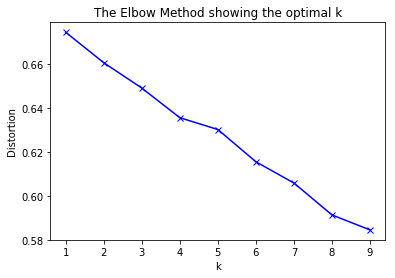

In [87]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_jobs=4)
    kmeanModel.fit(clf)
    distortions.append(sum(np.min(cdist(clf, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / clf.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

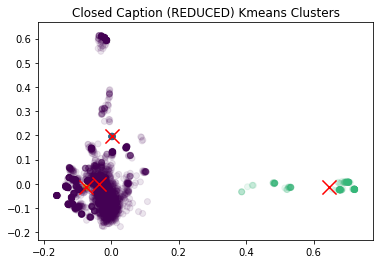

In [88]:
#with SVD 4000

num_clusters = 4
km = KMeans(n_clusters=num_clusters, n_jobs=4) 
km.fit(clf)

clusters = km.labels_.tolist()

#plot

pca = PCA(n_components=2).fit(clf)
data2D = pca.transform(clf)
plt.scatter(data2D[:,0], data2D[:,1], c=clusters, alpha=0.1)

centers2D = pca.transform(km.cluster_centers_)

plt.scatter(centers2D[:,0], centers2D[:,1], 
            marker='x', s=200, linewidths=3, c='r')
plt.title('Closed Caption (REDUCED) Kmeans Clusters')
plt.show() 

In [89]:
#common words by cluster

words_eng = vectorizer.get_feature_names()
common_words = km.cluster_centers_.argsort()[:,-1:-100:-1]

for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words_eng[word] for word in centroid))

0 : aaa, aaas, aafl, aaaand, aaaahhhh, aaahhh, aalpproveal, abandoning, abacus, abandons, aarp, aauthentic, aamerica, abducting, aaaah, abdomen, ababouout, abandoned, aargh, abbeville, abel, abbut, abandonment, aau, abcor, aback, aawww, aaid, abide, abigail, ablishing, abode, aboard, abbeys, abele, abfi, abilities, abbie, abolishment, abolish, abject, abilityout, abilit, abnormalities, abernethy, abi, abnormal, abili, abiding, abominable, abolished, aak, aboarding, abceyewitness, abates, abetting, abnormally, abo, abcnews, ablaze, able, abilityabi, aah, abolition, aar, abigl, abby, abc, abington, abomination, aboboutut, abolishing, abilitile, abdul, abercrombie, abe, abbey, ablib, abducted, abcn, abduction, abandon, ability, aaron, abdominal, aat, aarhus, aalways, aarar, abduct, abatement, abbott, aahh, aaghhh, aabrand, aaaaah, aaah, aac, aab
1 : aab, aabrand, aaa, aaaahhhh, aaaah, aaaaah, aaahhh, aaron, aalways, abernethy, abandon, aaah, abatement, abduct, abbey, abbeville, abdominal,

In [90]:
words_eng

['aaa',
 'aaaaaaah',
 'aaaaah',
 'aaaah',
 'aaaahhhh',
 'aaaand',
 'aaah',
 'aaahhh',
 'aaas',
 'aab',
 'aabrand',
 'aac',
 'aafl',
 'aaghhh',
 'aah',
 'aahh',
 'aaid',
 'aak',
 'aalpproveal',
 'aalways',
 'aamerica',
 'aar',
 'aarar',
 'aargh',
 'aarhus',
 'aaron',
 'aarp',
 'aat',
 'aau',
 'aauthentic',
 'aawww',
 'ababouout',
 'aback',
 'abacus',
 'abandon',
 'abandoned',
 'abandoning',
 'abandonment',
 'abandons',
 'abatement',
 'abates',
 'abbeville',
 'abbey',
 'abbeys',
 'abbie',
 'abbott',
 'abbut',
 'abby',
 'abc',
 'abceyewitness',
 'abcn',
 'abcnews',
 'abcor',
 'abdomen',
 'abdominal',
 'abduct',
 'abducted',
 'abducting',
 'abduction',
 'abdul',
 'abe',
 'abel',
 'abele',
 'abercrombie',
 'abernethy',
 'abetting',
 'abfi',
 'abi',
 'abide',
 'abiding',
 'abigail',
 'abigl',
 'abili',
 'abilit',
 'abilities',
 'abilitile',
 'ability',
 'abilityabi',
 'abilityout',
 'abington',
 'abject',
 'ablaze',
 'able',
 'ablib',
 'ablishing',
 'abnormal',
 'abnormalities',
 'abnormally

In [52]:
#span 4000

spanf_text = df_spanf['cleaned'].values
list_spanf = spanf_text.tolist()

In [54]:
#4000
num_clusters = 3
vectorizers = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True) 
tfidf_models = vectorizers.fit_transform(list_spanf)

svds = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
clfs = svds.fit_transform(tfidf_models) 

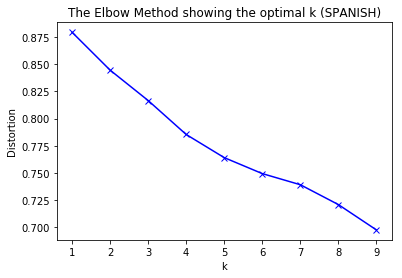

In [55]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(clfs)
    distortions.append(sum(np.min(cdist(clfs, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / clfs.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k (SPANISH)')
plt.show()

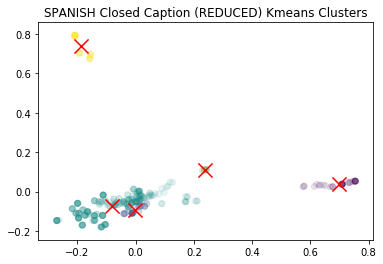

In [61]:
#with SVD span 4000

num_clusters = 5
kms = KMeans(n_clusters=num_clusters, n_jobs=4) 
kms.fit(clfs)

clusters = kms.labels_.tolist()

#plot

pcas = PCA(n_components=2).fit(clfs)
data2D = pcas.transform(clfs)
plt.scatter(data2D[:,0], data2D[:,1], c=clusters, alpha=0.1)

centers2D = pcas.transform(kms.cluster_centers_)

plt.scatter(centers2D[:,0], centers2D[:,1], 
            marker='x', s=200, linewidths=3, c='r')
plt.title('SPANISH Closed Caption (REDUCED) Kmeans Clusters')
plt.show() 

In [65]:
#common words by cluster

words = vectorizers.get_feature_names()
common_words = kms.cluster_centers_.argsort()[:,-1:-100:-1]

for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : 000, 00, 008, 01, 06, 05, 29, 08, 04, 280, 1en, 45, 37, 09, 20de09, 07, 10, 2018, 150, 32, 20, 13, 1942, 25, 27, 44, 33, 42, 34, 22, 39, 350, 99, 100, 500, 56, aaaahhh, 47, 59, 55, aaaaaah, 947, 69, 23, 4l70e, 58, 43, 46, 16, 800, 54, 58omentos, 80, 400, 40, aaaaaahhh, 67en, aarp, aacá, 700, 5bright, 53, 38, 48, 180, 31, 52, 57, 65, 51, 090, 50, 14, 11, 3que, 36, 45mil, 130, 41, 35, 30, 19, 200, 21, 15, 17, 0luego, 18, 420, 24, 2001, 03, 26, 058, 28, 125, 375, 120, 12
1 : 00, 02, 04, 05, 000, 06, 25, 10, 0luego, 100, 24, 21, 13, 200, 120, 09, 16, 20, 058, 125, 32, 14, 375, 30, 5bright, 23, 350, 15, 19, 20de09, 37, 4l70e, 67en, 1942, aaaaaahhh, 46, 45, 947, 57, 54, 27, 69, 99, aacá, 43, 500, 40, aaaaaah, 44, 41, 53, 51, 700, 28, 80, 33, 280, 800, 56, 45mil, 400, aarp, 59, 3que, 50, 42, 34, 47, 58omentos, 18, aaaahhh, 52, 36, 31, 58, 65, 39, 55, 35, 38, 48, 420, 1en, 090, 29, 2001, 180, 17, 11, 22, 2018, 130, 26, 07, 12, 03, 150, 08, 008
2 : 00, 058, 01, 17, 120, 12, 26, 10, 19, 47, 

In [71]:
#vectorize and svd fit_transform output is dense matrix

num_clusters = 3
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True) 
tfidf_model = vectorizer.fit_transform(list_eng)

svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
clf = svd.fit_transform(tfidf_model) 

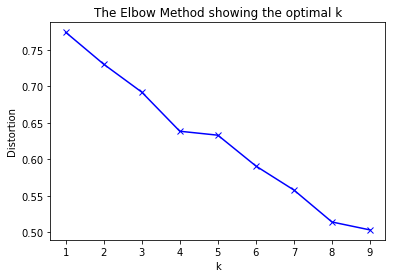

In [61]:
# k means determine k for 1000 docs

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(clf)
    distortions.append(sum(np.min(cdist(clf, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / clf.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

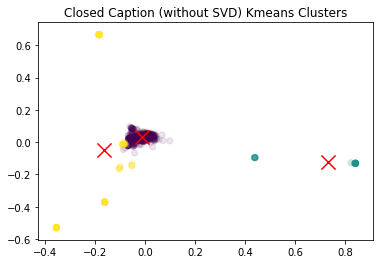

In [70]:
# without SVD 1000

num_clusters = 3
km = KMeans(n_clusters=num_clusters) 
km.fit(tfidf_model)

clusters = km.labels_.tolist()

X = tfidf_model.todense()

#plot

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c=clusters, alpha=0.1)

centers2D = pca.transform(km.cluster_centers_)

plt.scatter(centers2D[:,0], centers2D[:,1], 
            marker='x', s=200, linewidths=3, c='r')
plt.title('Closed Caption (without SVD) Kmeans Clusters')
plt.show()  

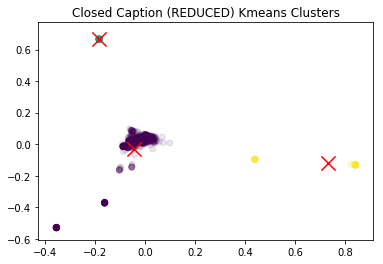

In [74]:
#with SVD 1000

num_clusters = 3
km = KMeans(n_clusters=num_clusters) 
km.fit(clf)

clusters = km.labels_.tolist()

#plot

pca = PCA(n_components=2).fit(clf)
data2D = pca.transform(clf)
plt.scatter(data2D[:,0], data2D[:,1], c=clusters, alpha=0.1)

centers2D = pca.transform(km.cluster_centers_)

plt.scatter(centers2D[:,0], centers2D[:,1], 
            marker='x', s=200, linewidths=3, c='r')
plt.title('Closed Caption (REDUCED) Kmeans Clusters')
plt.show() 

In [73]:
eng_terms = vectorizer.get_feature_names()
eng_terms

['00',
 '000',
 '01',
 '010',
 '02',
 '04',
 '041',
 '05',
 '06',
 '062',
 '07',
 '0779hj',
 '0822yj',
 '09',
 '10',
 '100',
 '100th',
 '10pc',
 '10th',
 '10th1',
 '10tv',
 '11',
 '110th',
 '112',
 '115',
 '116',
 '11th',
 '11thth',
 '12',
 '120',
 '121',
 '124',
 '125',
 '12k',
 '12k6',
 '12s',
 '12th',
 '13',
 '137th',
 '13an',
 '13th',
 '14',
 '142',
 '144',
 '14th',
 '15',
 '150',
 '15th',
 '16',
 '160',
 '160th',
 '163rd',
 '163s',
 '16th',
 '17',
 '170',
 '1700s',
 '170th',
 '1712',
 '17th',
 '18',
 '180',
 '1860s',
 '186sot',
 '1870s',
 '18th',
 '19',
 '1900s',
 '192',
 '1920s',
 '1940s',
 '1950s',
 '1960s',
 '1980s',
 '1992',
 '19th',
 '1nd',
 '1st',
 '1xtra',
 '20',
 '200',
 '2002',
 '2006ing',
 '200th',
 '2015',
 '2018',
 '2019',
 '20th',
 '21',
 '22',
 '221',
 '23',
 '23rd',
 '24',
 '247',
 '24th',
 '25',
 '250',
 '250k',
 '25mbps',
 '25th',
 '26',
 '262',
 '26th',
 '27',
 '276',
 '27th',
 '28th',
 '29',
 '299',
 '29a',
 '29th',
 '2nd',
 '2news',
 '30',
 '300',
 '300th',
 '3

In [75]:
type(clf)

numpy.ndarray

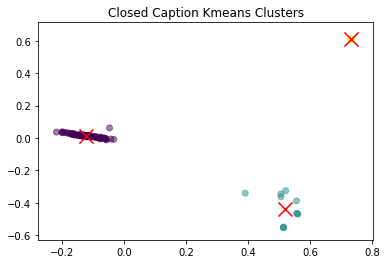

In [552]:
#no svd reduction 100

num_clusters = 3
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True) 
tfidf_model = vectorizer.fit_transform(all_docs)

km = KMeans(n_clusters=num_clusters) 
km.fit(tfidf_model)

clusters = km.labels_.tolist()

X = tfidf_model.todense()

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c=clusters, alpha=0.5)

centers2D = pca.transform(km.cluster_centers_)

plt.scatter(centers2D[:,0], centers2D[:,1], 
            marker='x', s=200, linewidths=3, c='r')
plt.title('Closed Caption Kmeans Clusters')
plt.show()  

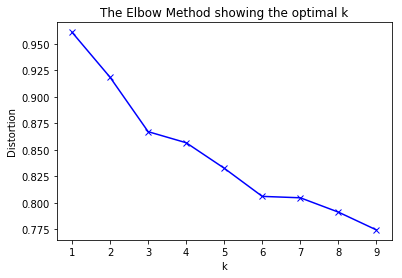

In [553]:
# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(tfidf_model)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

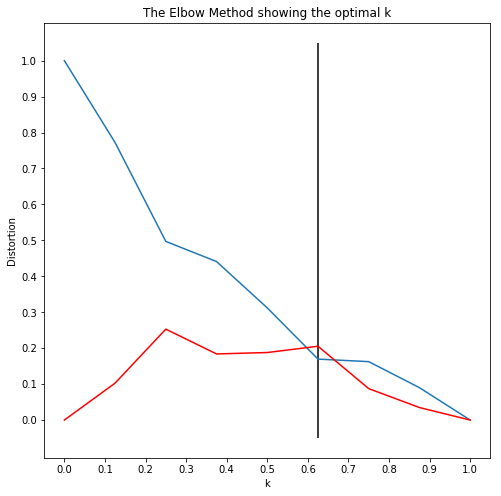

In [559]:


knee = knee_locator.KneeLocator(K, distortions, curve='convex', direction='decreasing')

knee.plot_knee_normalized()
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k');

In [443]:
knee.knee

5

In [560]:
term = vectorizer.get_feature_names()
term

['00',
 '000',
 '01',
 '02',
 '04',
 '06',
 '10',
 '100',
 '11',
 '110th',
 '112',
 '12',
 '121',
 '124',
 '125',
 '12k6',
 '12th',
 '13',
 '13th',
 '142',
 '15',
 '16',
 '163rd',
 '17',
 '170',
 '18',
 '180',
 '1942',
 '1st',
 '1xtra',
 '20',
 '200',
 '2015',
 '2018',
 '22',
 '23',
 '24',
 '247',
 '25',
 '25th',
 '26',
 '276',
 '29',
 '2nd',
 '30',
 '300',
 '36',
 '39',
 '400',
 '405',
 '40s',
 '410',
 '42nd',
 '50',
 '500',
 '50s',
 '55',
 '590',
 '60',
 '600',
 '601',
 '60s',
 '627',
 '64',
 '65',
 '700',
 '70s',
 '750',
 '76ers',
 '799',
 '80',
 '800',
 '80s',
 '819',
 '825',
 '838',
 '850',
 '86',
 '875',
 '8th',
 '900',
 '90s',
 '99',
 'a1c',
 'aaa',
 'aaaaaah',
 'aaaaaahhh',
 'aah',
 'aarp',
 'abajo',
 'abc',
 'abc10',
 'abdominal',
 'abetting',
 'abierta',
 'ability',
 'able',
 'abner',
 'abnormal',
 'abnormalities',
 'abogado',
 'abogados',
 'abortion',
 'abraham',
 'abran',
 'abrazo',
 'abreu',
 'abrir',
 'abriste',
 'abrió',
 'abroad',
 'abs',
 'absolutely',
 'absorbe',
 'ab

## Sentiment Analysis

In [377]:


analyser = SentimentIntensityAnalyzer()

In [361]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{}".format(str(score)))

In [363]:
# vader sentiment score @ cleaned text

score = sentiment_analyzer_scores(all_docs[0])
print(score)

{'neg': 0.079, 'neu': 0.726, 'pos': 0.195, 'compound': 0.9995}
None


In [576]:
#vader sentiment score @ raw text

score_raw = sentiment_analyzer_scores(doc_list[0])
print(score_raw)

{'neg': 0.111, 'neu': 0.698, 'pos': 0.19, 'compound': 0.9996}
None


In [583]:
type(score_raw)

NoneType

In [ ]:
scores = []

for sentence in sentences:
    score = analyser.polarity_scores(sentence)
    scores.append(score)
    
dataFrame= pd.DataFrame(scores)

## Language Detection

In [513]:
detect(all_docs[0])

'en'

In [514]:
count1 = 0
count2 = 0

for doc in all_docs:
   
    if detect(doc) == 'en':
        count1 += 1
    elif detect(doc) == 'es':
        count2 += 1
    else:
        break
count1, count2

(83, 17)

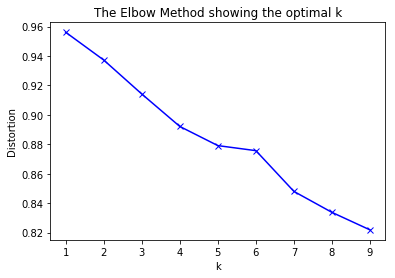

In [545]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(clf)
    distortions.append(sum(np.min(cdist(clf, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / clf.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

## EC2 AWS Spark

use alberto_first_key.pem

$scp -i ~/Desktop/amazon.pem ~/Desktop/MS115.fa  ubuntu@ec2-54-166-128-20.compute-1.amazonaws.com:~/data/
<br> to copy files from laptop to EC2<br>
$scp -i ~/Desktop/amazon.pem ubuntu@ec2-54-166-128-20.compute-1.amazonaws.com:/data/ecoli_ref-5m-trim.fastq.gz ~/Download/
<br> ec2 to laptop


In [77]:
# $scp -i ~/.ssh/alberto_first_key.pem ~/galvanize/closed_caption_classifier  ubuntu@ec2-54-144-57-214.compute-1.amazonaws.com:~/data/

# to copy files from laptop to EC2

# $scp -i ~/Desktop/amazon.pem ubuntu@ec2-54-166-128-20.compute-1.amazonaws.com:/data/ecoli_ref-5m-trim.fastq.gz ~/Download/

# ec2 to laptop


In [65]:
# KMeans clustering on first 100

# def process_text(text, stem=True):
#     """ Tokenize text and stem words removing punctuation """
#     #text = text.translate(string.punctuation)
#     tokens = word_tokenize(text)
#     return tokens

def cluster_texts(texts, clusters=7):
    """ Transform texts to Tf-Idf coordinates and cluster texts using K-Means """
    
    vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True)
    tfidf_model = vectorizer.fit_transform(texts)
    
    km_model = KMeans(n_clusters=clusters)
    km_model.fit(tfidf_model)
 
    clustering = collections.defaultdict(list)
 
    for idx, label in enumerate(km_model.labels_):
        clustering[label].append(idx)
 
    return clustering

In [67]:
#Kmeans

clustering = cluster_texts(msgs)

In [68]:
clusters = []
for k,v in clustering.items():
    clusters.append(v)
print(clusters)

[[0, 1, 3, 4, 7, 8, 12, 16, 20, 25, 29, 31, 33, 35, 39, 45, 49, 55, 56, 58, 59, 60, 63, 64, 70, 73, 74, 75, 76, 77, 78, 79, 80, 83, 85, 86, 88, 93, 95, 96], [2, 30, 34, 36, 38, 48, 50, 53, 72, 82, 89, 91], [5, 6, 13, 15, 22, 24, 28, 32, 37, 41, 43, 44, 51, 52, 54, 62, 65, 66, 81, 84, 87, 97, 99], [9, 11, 17, 18, 27, 46, 57, 67, 68, 71, 98], [10, 14, 26, 40, 47, 90], [19, 23, 69, 92, 94], [21, 42, 61]]


In [35]:
centroids = km_model.cluster_centers_
km_model.
centroids

array([[0.28571429, 2.48214286, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.77777778, 1.22222222, 0.37037037, ..., 0.        , 0.        ,
        0.        ],
       [0.35294118, 0.82352941, 0.        , ..., 1.05882353, 0.41176471,
        0.52941176]])

In [89]:
num_clusters = 5

vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True)
tfidf_model = vectorizer.fit_transform(msgs)

km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_model)

clusters = km.labels_.tolist()

In [90]:
from sklearn.externals import joblib

#joblib.dump(km,  'data/cc_100_cluster.pkl')

km = joblib.load('data/cc_100_cluster.pkl')
clusters = km.labels_.tolist()

In [ ]:
#clusters

In [95]:
terms = vectorizer.get_feature_names()
terms

['00',
 '000',
 '01',
 '02',
 '030',
 '04',
 '06',
 '0h',
 '10',
 '100',
 '1000',
 '1001',
 '10010',
 '1002',
 '100400',
 '10077',
 '101',
 '1013',
 '1018',
 '10244',
 '102502',
 '103203',
 '1033',
 '1034',
 '1035',
 '1036',
 '10410',
 '105',
 '105038',
 '1051',
 '10511',
 '10644',
 '1067',
 '1068',
 '1069',
 '10711',
 '108',
 '108008',
 '10811',
 '1084',
 '10844',
 '108775',
 '109',
 '10911',
 '10a',
 '10s',
 '11',
 '110',
 '110010',
 '1100s',
 '1101',
 '1102',
 '11078',
 '110th',
 '111411',
 '1118',
 '112',
 '11211',
 '11245',
 '11278',
 '112813',
 '113',
 '1134',
 '1135',
 '1136',
 '11478',
 '115',
 '1151',
 '11512',
 '11545',
 '116617',
 '1167',
 '1168',
 '1169',
 '11712',
 '11845',
 '1185',
 '119',
 '11th',
 '12',
 '120',
 '1200',
 '1201',
 '1202',
 '12045',
 '12079',
 '121',
 '1218',
 '12279',
 '123',
 '123023',
 '1234',
 '1235',
 '124',
 '12479',
 '125',
 '1251',
 '125492',
 '12579',
 '12646',
 '1267',
 '1268',
 '1269',
 '127',
 '127060',
 '127075',
 '1285',
 '12k6',
 '12th',
 '

In [15]:
vectorizer = CountVectorizer().fit_transform(msgs)

In [463]:


km_model = KMeans(n_clusters=3)
km_model.fit(vectorizer)
 
clustering = collections.defaultdict(list)
 
for idx, label in enumerate(km_model.labels_):
    clustering[label].append(idx)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
clustering

defaultdict(list,
            {0: [0,
              1,
              3,
              4,
              7,
              8,
              12,
              13,
              15,
              16,
              19,
              20,
              23,
              25,
              29,
              31,
              32,
              33,
              35,
              36,
              37,
              39,
              41,
              43,
              45,
              49,
              55,
              56,
              58,
              59,
              60,
              62,
              63,
              64,
              66,
              69,
              70,
              74,
              75,
              76,
              77,
              79,
              80,
              81,
              83,
              84,
              87,
              88,
              89,
              91,
              92,
              93,
              94,
              95,
             

In [456]:
#df_nano.to_json('data/cc_100_text.json')

In [493]:
p = Pipeline([('clean', P.CleanAllDocs()),
            ('kmeans', P.K_Means())])

In [492]:
df = pd.read_csv('data/cc_100_text.csv')
date_series = pd.Series(df['created_at'].values)
dates = date_series.apply(lambda x: x.get('$date'))
type(date_series)

pandas.core.series.Series

In [485]:
clean = P.CleanAllDocs()

In [80]:
import spacy

In [81]:
nlp = spacy.load('en_core_web_sm')

In [133]:
document = nlp(all_docs[1])

spacy.tokens.doc.Doc

In [135]:
def cleanup(token, lower = True):
    if lower:
       token = token.lower()
    return token.strip()

In [145]:
document_tokens = nltk.word_tokenize(all_docs[0])
document_tokents = str(document_tokens)

In [116]:
def get_entities(doc_string):
    doc_string1 = nlp(doc_string)
    labels = set([w.label_ for w in doc_string1.ents]) 
    for label in labels: 

        temp_entities = [cleanup(e.string, lower=False) for e in doc_string1.ents if label==e.label_] 
        temp_entities = list(set(temp_entities)) 
        return label, temp_entities

In [155]:
# all english text

all_ents = []
for doc in list_eng:
    ents = get_entities(doc)
    all_ents.append(ents)

In [158]:
all_ents[1]

('CARDINAL', ['three', 'two', 'one', 'thousand', 'six'])

In [ ]:
ssh -N -f -L localhost:8888:localhost:8886 -i ~/.ssh/alberto_first_key.pem ubuntu@ec2-54-144-57-214.compute-1.amazonaws.com


In [154]:
document_tokens = cleanup(all_docs[4])
document_tokens = nlp(document_tokens)

labels = set([w.label_ for w in document_tokens.ents]) 
for label in labels: 

    temp_entities = [e for e in document_tokens.ents if label==e.label_] 
    temp_entities = list(set(temp_entities)) 
    print(label, temp_entities)

PERCENT [fifteen percent]
CARDINAL [one, three, 4,000, one, one, one, two, two, one]
DATE [month years, today, today]
ORDINAL [first, first, first, first, first]
TIME [fifteen minutes]
NORP [chinese]


In [482]:
# data2 = 'data/cc_chunks.json'
# chunks2 = pd.read_json(data2, lines=True, chunksize=100)



## Visualizations

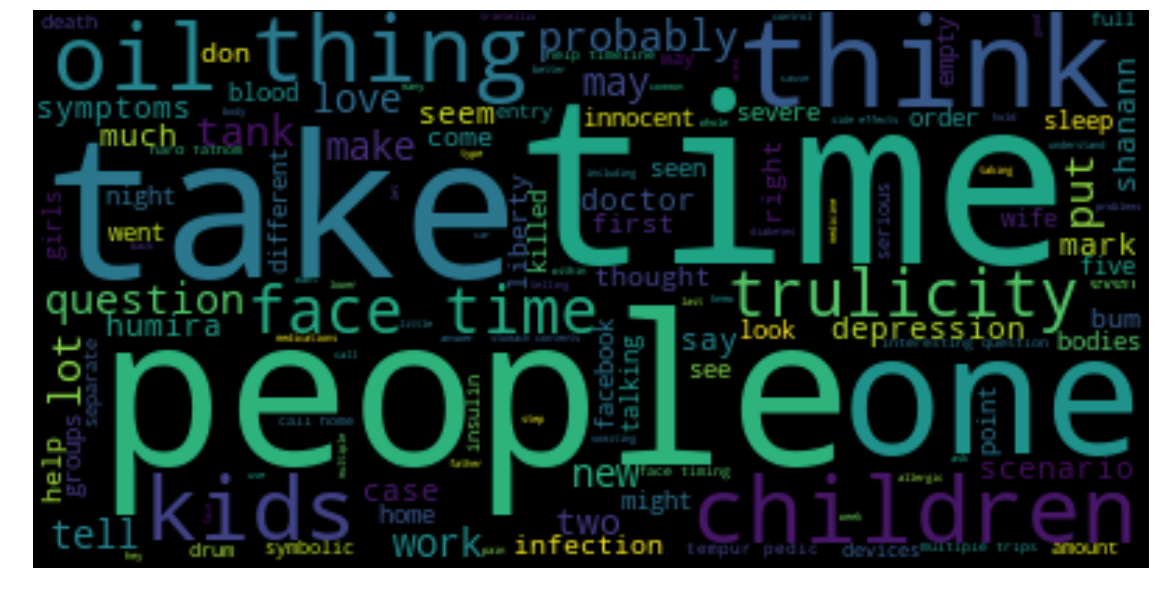

In [181]:
#word cloud

text = list_eng[11]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.figure(figsize=(20, 50))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
#for pipeline try mnbayes vs kmeans

class NaiveBayes(BaseEstimator, TransformerMixin):

    def fit(self, X, y):
        corpus = []
        for i in range(len(y)):
            soup = BeautifulSoup(X['description'].iloc[i], 'lxml')
            soup = soup.text
            soup = soup.lower()
            corpus.append(soup)
        vector = TfidfVectorizer(stop_words='english')
        self.vector = vector
        matrix = vector.fit_transform(corpus)
        clf = MultinomialNB().fit(matrix, y)
        self.clf = clf
        return self

    def transform(self, X):
        nbayes = self.clf.predict_proba(self.vector.transform(X['description']))[:, 1]
        X['n_bayes'] = nbayes
        return X

In [52]:
http://brandonrose.org/clustering
# word list by cluster

from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

SyntaxError: invalid syntax (<ipython-input-52-60d252b1dacd>, line 1)

In [ ]:
# remove parenthetical phrases
input_text_noparens = re.sub(r'\([^)]*\)', '', input_text)

# store as list of sentences
sentences_strings_ted = []
for line in input_text_noparens.split('\n'):
    m = re.match(r'^(?:(?P<precolon>[^:]{,20}):)?(?P<postcolon>.*)$', line)
    sentences_strings_ted.extend(sent for sent in m.groupdict()['postcolon'].split('.') if sent)
    
# store as list of lists of words
sentences_ted = []
for sent_str in sentences_strings_ted:
    tokens = re.sub(r"[^a-z0-9]+", " ", sent_str.lower()).split()
    sentences_ted.append(tokens)